In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TravelInsurancePrediction.csv')
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [ ]:
df['FrequentFlyer'] = df['FrequentFlyer'].map({'Yes': 1, 'No': 0})
df['EverTravelledAbroad'] = df['EverTravelledAbroad'].map({'Yes': 1, 'No': 0})
df['GraduateOrNot'] =  df['GraduateOrNot'].map({'Yes': 1, 'No': 0})
df["Employment Type"] = df["Employment Type"].map({"Government Sector" : 1, "Private Sector/Self Employed" : 0})

df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,1,1,400000,6,1,0,0,0
1,31,0,1,1250000,7,0,0,0,0
2,34,0,1,500000,4,1,0,0,1
3,28,0,1,700000,3,1,0,0,0
4,28,0,1,700000,8,1,1,0,0


In [ ]:
df['TravelInsurance'].value_counts()

0    1277
1     710
Name: TravelInsurance, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    return df_copy

In [ ]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 층화추출 기반 균등분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

In [ ]:
import time
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    start_time = time.time()
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    get_clf_eval(tgt_test, pred)
    print("수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

In [ ]:
X_train, X_test, y_train, y_test = get_train_test_dataset(df)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1390, 8) (1390,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (1786, 8) (1786,)
SMOTE 적용 후 레이블 값 분포: 
 1    893
0    893
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
get_model_train_eval(rf_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[313  71]
 [ 77 136]]
정확도: 0.7521, 정밀도: 0.6570, 재현율: 0.6385, F1: 0.6476
수행 시간: 3.2 초 


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV

dtree = DecisionTreeClassifier()


parameters = {'max_depth':[1,2,3], 'min_samples_split':[2,3]}

grid_dtree = GridSearchCV(dtree, param_grid=parameters, cv=3, refit=True)

grid_dtree.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_dtree.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score','split0_test_score', 'split1_test_score', 'split2_test_score']]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.784168,3,0.790948,0.779698,0.781857
1,"{'max_depth': 1, 'min_samples_split': 3}",0.784168,3,0.790948,0.779698,0.781857
2,"{'max_depth': 2, 'min_samples_split': 2}",0.783449,5,0.788793,0.779698,0.781857
3,"{'max_depth': 2, 'min_samples_split': 3}",0.783449,5,0.788793,0.779698,0.781857
4,"{'max_depth': 3, 'min_samples_split': 2}",0.835251,1,0.836207,0.825054,0.844492
5,"{'max_depth': 3, 'min_samples_split': 3}",0.835251,1,0.836207,0.825054,0.844492


In [ ]:
estimator = grid_dtree.best_estimator_

In [ ]:
from sklearn.tree import export_graphviz

# export_graphviz()의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함. 
export_graphviz(estimator, out_file="best_tree.dot", 
                impurity=True, 
                filled=True)

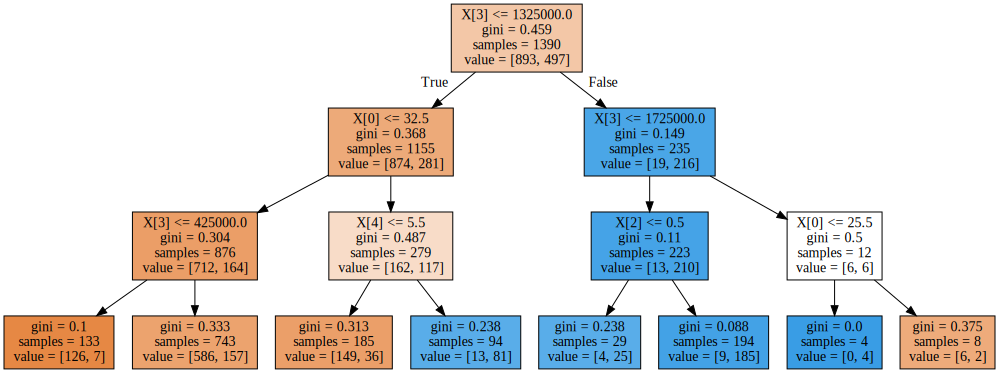

In [ ]:
import graphviz

# 위에서 생성된 tree.dot 파일을 Graphviz 읽어서 Jupyter Notebook상에서 시각화 
with open("best_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
df

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,1,1,400000,6,1,0,0,0
1,31,0,1,1250000,7,0,0,0,0
2,34,0,1,500000,4,1,0,0,1
3,28,0,1,700000,3,1,0,0,0
4,28,0,1,700000,8,1,1,0,0
...,...,...,...,...,...,...,...,...,...
1982,33,0,1,1500000,4,0,1,1,1
1983,28,0,1,1750000,5,1,0,1,0
1984,28,0,1,1150000,6,1,0,0,0
1985,34,0,1,1000000,6,0,1,1,1
